# RND Buffer-Based Incremental Training Experiments

This notebook implements a **buffer-based incremental training** approach for RND (Random Network Distillation).

## Key Differences from Standard Training

### Standard Approach (in `precomputed_experiments.ipynb`)
- For each epoch, iterate over ALL batches in training data
- Repeat for `num_epochs`

### Buffer-Based Approach (this notebook)
- Maintain a **fixed-size buffer** (queue) of recent batches
- For each new batch:
  1. Add batch to buffer (remove oldest if buffer is full - FIFO)
  2. Train for `num_epochs` on the current buffer contents
  3. Evaluate on held-out test set
- Continue until all training batches are processed

## Motivation
This simulates online/streaming learning where:
- We don't have access to all data at once
- We focus training on recent experiences
- We can track how RND rewards evolve as new data is seen

## Evaluation Strategy
- Hold out a fixed test set (by problem, keeping all 3 solutions together)
- After each buffer update + training, evaluate rewards for all 3 solutions per problem
- Track variance across solutions to understand RND behavior

## Metrics
- **Per-problem variance**: How differently does RND score the 3 solutions for each problem?
- **Reward trajectories**: How do rewards for each solution evolve over training?
- **Consistency**: Which problems show stable vs. fluctuating rewards?

## Section 1: Imports and Setup

In [60]:
import random
import json
import pickle
import time
from pathlib import Path
from datetime import datetime
from collections import deque
from typing import Dict, List, Tuple, Optional

import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('..')
from rnd import RNDModule

# Model name mapping (for reference)
ENCODER_MODELS = {
    'granite': 'ibm-granite/granite-embedding-english-r2',
    'granite-small': 'ibm-granite/granite-embedding-small-english-r2',
    'gte': 'Alibaba-NLP/gte-modernbert-base'
}

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [61]:
import os

## Section 2: Load Precomputed Embeddings

In [62]:
def load_precomputed_embeddings(encoder_name: str, num_samples: int, save_dir: str = 'embeddings'):
    """
    Load pre-computed embeddings from disk.
    
    Args:
        encoder_name: Short name ('gte', 'granite', 'granite-small')
        num_samples: Number of samples (used in filename)
        save_dir: Directory where embeddings are saved
    
    Returns:
        dict: Contains 'problem_embs', 'solution1_embs', 'solution2_embs', 'solution3_embs',
              'embedding_dim', 'encoder_name', 'num_samples'
    """
    filepath = f"{save_dir}/embeddings_{encoder_name}_{num_samples}.pkl"
    
    if not Path(filepath).exists():
        raise FileNotFoundError(
            f"Embeddings file not found: {filepath}\n"
            f"Please run precomputed_experiments.ipynb Section 1 to pre-compute embeddings first."
        )
    
    print(f"Loading embeddings from {filepath}...")
    with open(filepath, 'rb') as f:
        embeddings_data = pickle.load(f)
    
    file_size_mb = Path(filepath).stat().st_size / (1024 * 1024)
    print(f"✓ Loaded {file_size_mb:.2f} MB")
    print(f"✓ Embedding dim: {embeddings_data['embedding_dim']}")
    print(f"✓ Num samples: {embeddings_data['num_samples']}")
    print(f"✓ Shapes:")
    print(f"    problem_embs: {embeddings_data['problem_embs'].shape}")
    print(f"    solution1_embs: {embeddings_data['solution1_embs'].shape}")
    print(f"    solution2_embs: {embeddings_data['solution2_embs'].shape}")
    print(f"    solution3_embs: {embeddings_data['solution3_embs'].shape}")
    
    return embeddings_data

In [90]:
# Load embeddings - configure these parameters
ENCODER_NAME = 'gte'  # Options: 'gte', 'granite', 'granite-small'
NUM_SAMPLES = 12000   # Number of samples in the embedding file
LOAD_DIR = 'embeddings'
SAVE_DIR = 'results2'

embeddings_data = load_precomputed_embeddings(ENCODER_NAME, NUM_SAMPLES, LOAD_DIR)

Loading embeddings from embeddings/embeddings_gte_12000.pkl...
✓ Loaded 140.63 MB
✓ Embedding dim: 768
✓ Num samples: 12000
✓ Shapes:
    problem_embs: torch.Size([12000, 768])
    solution1_embs: torch.Size([12000, 768])
    solution2_embs: torch.Size([12000, 768])
    solution3_embs: torch.Size([12000, 768])


## Section 3: Train/Test Split

Split the data into training and test sets **by problem** (keeping all 3 solutions together for each problem).

In [64]:
def train_test_split_by_problem(
    embeddings_data: Dict,
    num_test_problems: int,
    concat_problem_answer: bool = False,
    seed: int = 42
) -> Tuple[Dict, Dict]:
    """
    Split embeddings into train and test sets by problem.
    
    Each problem has 3 solutions, so we keep all solutions together.
    All 3 solutions are included in both train and test sets.
    
    Args:
        embeddings_data: Dict from load_precomputed_embeddings()
        num_test_problems: Number of problems to hold out for testing
        concat_problem_answer: If True, concatenate problem and solution embeddings
        seed: Random seed for reproducibility
    
    Returns:
        train_data: Dict with all 3 solution embeddings for training
        test_data: Dict with all 3 solution embeddings for evaluation
    """
    num_total_problems = embeddings_data['num_samples']
    num_train_problems = num_total_problems - num_test_problems
    
    assert num_test_problems < num_total_problems, "Test set size must be smaller than total"
    assert num_test_problems > 0, "Test set must have at least 1 problem"
    
    # Shuffle problem indices
    torch.manual_seed(seed)
    np.random.seed(seed)
    indices = torch.randperm(num_total_problems)
    
    train_indices = indices[:num_train_problems]
    test_indices = indices[num_train_problems:]
    
    # Extract embeddings
    problem_embs = embeddings_data['problem_embs']
    solution1_embs = embeddings_data['solution1_embs']
    solution2_embs = embeddings_data['solution2_embs']
    solution3_embs = embeddings_data['solution3_embs']
    
    if concat_problem_answer:
        # Concatenate problem and solution embeddings
        sol1 = torch.cat([problem_embs, solution1_embs], dim=1)
        sol2 = torch.cat([problem_embs, solution2_embs], dim=1)
        sol3 = torch.cat([problem_embs, solution3_embs], dim=1)
        embedding_dim = problem_embs.shape[1] * 2
    else:
        sol1 = solution1_embs
        sol2 = solution2_embs
        sol3 = solution3_embs
        embedding_dim = solution1_embs.shape[1]
    
    # Create train data (ALL 3 solutions for training)
    train_data = {
        'solution1_embs': sol1[train_indices],
        'solution2_embs': sol2[train_indices],
        'solution3_embs': sol3[train_indices],
        'problem_embs': problem_embs[train_indices],
        'embedding_dim': embedding_dim,
        'num_problems': num_train_problems,
        'indices': train_indices
    }
    
    # Create test data (all 3 solutions for evaluation)
    test_data = {
        'solution1_embs': sol1[test_indices],
        'solution2_embs': sol2[test_indices],
        'solution3_embs': sol3[test_indices],
        'problem_embs': problem_embs[test_indices],
        'embedding_dim': embedding_dim,
        'num_problems': num_test_problems,
        'indices': test_indices
    }
    
    print(f"\n📊 Train/Test Split Summary:")
    print(f"  Total problems: {num_total_problems}")
    print(f"  Train problems: {num_train_problems}")
    print(f"  Test problems: {num_test_problems}")
    print(f"  Embedding dim: {embedding_dim}")
    print(f"  Concat problem+answer: {concat_problem_answer}")
    print(f"  Solutions used for training: ALL 3")
    
    return train_data, test_data

In [65]:
# Configure train/test split
NUM_TEST_PROBLEMS = 500  # Number of problems to hold out for evaluation
CONCAT_PROBLEM_ANSWER = True  # Whether to concatenate problem and answer embeddings

train_data, test_data = train_test_split_by_problem(
    embeddings_data,
    num_test_problems=NUM_TEST_PROBLEMS,
    concat_problem_answer=CONCAT_PROBLEM_ANSWER,
    seed=42
)


📊 Train/Test Split Summary:
  Total problems: 12000
  Train problems: 11500
  Test problems: 500
  Embedding dim: 1536
  Concat problem+answer: True
  Solutions used for training: ALL 3


## Section 4: Buffer-Based RND Training

Implement the buffer-based training approach:
1. Maintain a FIFO buffer of recent batches
2. For each new batch, train for multiple epochs on the buffer
3. Evaluate on test set after each batch

In [66]:
class BufferBasedRNDTrainer:
    """
    Buffer-based incremental RND trainer.
    
    Uses a FIFO buffer to store recent training batches.
    For each new batch, trains for multiple epochs on buffer contents.
    Evaluates on test set after each batch is processed.
    
    NOTE: All 3 solutions are used for both training and evaluation.
    """
    
    def __init__(
        self,
        embedding_dim: int,
        target_layers: Tuple[int, ...] = (256, 128, 64),
        predictor_layers: Tuple[int, ...] = (512, 256, 64),
        normalize_embeddings: bool = True,
        device: str = 'cuda'
    ):
        self.device = device
        self.embedding_dim = embedding_dim
        self.normalize_embeddings = normalize_embeddings
        
        self.rnd_model = RNDModule(
            input_dim=embedding_dim,
            target_layers=target_layers,
            predictor_layers=predictor_layers,
            device=device,
            normalize_embeddings=normalize_embeddings
        ).to(device)
    
    def initialize_normalizer(self, train_data: Dict, num_samples: int = 1000):
        if not self.normalize_embeddings:
            return
        
        sol1 = train_data['solution1_embs']
        sol2 = train_data['solution2_embs']
        sol3 = train_data['solution3_embs']
        
        num_available = sol1.shape[0]
        num_to_use = min(num_samples // 3, num_available)
        init_embs = torch.cat([sol1[:num_to_use], sol2[:num_to_use], sol3[:num_to_use]], dim=0)
        self.rnd_model.initialize_embedding_normalizer(init_embs.to(self.device))
    
    def evaluate_on_test_set(self, test_data: Dict, batch_size: int = 64) -> Dict:
        self.rnd_model.eval()
        
        sol1 = test_data['solution1_embs'].to(self.device)
        sol2 = test_data['solution2_embs'].to(self.device)
        sol3 = test_data['solution3_embs'].to(self.device)
        num_problems = test_data['num_problems']
        
        all_rewards_s1, all_rewards_s2, all_rewards_s3 = [], [], []
        num_batches = (num_problems + batch_size - 1) // batch_size
        
        with torch.no_grad():
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, num_problems)
                
                batch_s1 = sol1[start_idx:end_idx].unsqueeze(1)
                batch_s2 = sol2[start_idx:end_idx].unsqueeze(1)
                batch_s3 = sol3[start_idx:end_idx].unsqueeze(1)
                
                rewards_s1, _ = self.rnd_model(batch_s1, update_stats=False)
                rewards_s2, _ = self.rnd_model(batch_s2, update_stats=False)
                rewards_s3, _ = self.rnd_model(batch_s3, update_stats=False)
                
                all_rewards_s1.append(rewards_s1.flatten().cpu())
                all_rewards_s2.append(rewards_s2.flatten().cpu())
                all_rewards_s3.append(rewards_s3.flatten().cpu())
        
        return {
            'rewards_s1': torch.cat(all_rewards_s1).numpy(),
            'rewards_s2': torch.cat(all_rewards_s2).numpy(),
            'rewards_s3': torch.cat(all_rewards_s3).numpy()
        }
    
    def train_with_buffer(
        self,
        train_data: Dict,
        test_data: Dict,
        batch_size: int = 50,
        minibatch_size: int = 32,
        buffer_size_multiplier: int = 5,
        num_epochs_per_batch: int = 10,
        learning_rate: float = 1e-4,
        num_normalizer_samples: int = 1000,
        verbose: bool = True
    ) -> Dict:
        buffer_size = buffer_size_multiplier * batch_size
        sol1 = train_data['solution1_embs']
        sol2 = train_data['solution2_embs']
        sol3 = train_data['solution3_embs']
        num_train_problems = train_data['num_problems']
        num_batches = (num_train_problems + batch_size - 1) // batch_size
        
        if verbose:
            print(f"  Training: {num_train_problems} problems, {num_batches} batches")
            print(f"  Buffer: {buffer_size} ({buffer_size_multiplier}x{batch_size}), minibatch={minibatch_size}, {num_epochs_per_batch} epochs/batch")
        
        if self.normalize_embeddings and not self.rnd_model.embedding_stats_frozen:
            self.initialize_normalizer(train_data, num_samples=num_normalizer_samples)
        
        optimizer = torch.optim.Adam(self.rnd_model.predictor_parameters(), lr=learning_rate)
        scaler = GradScaler()
        
        buffer_sol1 = deque(maxlen=buffer_size)
        buffer_sol2 = deque(maxlen=buffer_size)
        buffer_sol3 = deque(maxlen=buffer_size)
        
        all_eval_results = []
        training_losses = []
        batch_timestamps = []
        
        initial_eval = self.evaluate_on_test_set(test_data)
        all_eval_results.append(initial_eval)
        batch_timestamps.append(0)
        
        start_time = time.time()
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_train_problems)
            
            batch_sol1 = sol1[start_idx:end_idx]
            batch_sol2 = sol2[start_idx:end_idx]
            batch_sol3 = sol3[start_idx:end_idx]
            
            for i in range(len(batch_sol1)):
                buffer_sol1.append(batch_sol1[i])
                buffer_sol2.append(batch_sol2[i])
                buffer_sol3.append(batch_sol3[i])
            
            buffer_tensor_sol1 = torch.stack(list(buffer_sol1)).to(self.device)
            buffer_tensor_sol2 = torch.stack(list(buffer_sol2)).to(self.device)
            buffer_tensor_sol3 = torch.stack(list(buffer_sol3)).to(self.device)
            buffer_len = len(buffer_sol1)
            
            batch_losses = []
            self.rnd_model.train()
            
            # For each epoch, sample minibatches with replacement from buffer
            for epoch in range(num_epochs_per_batch):
                # Sample minibatch_size indices with replacement
                sample_indices = torch.randint(0, buffer_len, (minibatch_size,), device=self.device)
                
                mb_sol1 = buffer_tensor_sol1[sample_indices].unsqueeze(1)
                mb_sol2 = buffer_tensor_sol2[sample_indices].unsqueeze(1)
                mb_sol3 = buffer_tensor_sol3[sample_indices].unsqueeze(1)
                mini_batch = torch.cat([mb_sol1, mb_sol2, mb_sol3], dim=1)
                
                with autocast():
                    _, loss = self.rnd_model(mini_batch, update_stats=True)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
                batch_losses.append(loss.item())
            
            avg_batch_loss = np.mean(batch_losses)
            training_losses.append(avg_batch_loss)
            
            eval_result = self.evaluate_on_test_set(test_data)
            all_eval_results.append(eval_result)
            batch_timestamps.append(batch_idx + 1)
            
            if verbose and ((batch_idx + 1) % 50 == 0 or batch_idx == num_batches - 1):
                elapsed = time.time() - start_time
                print(f"    Batch {batch_idx+1:3d}/{num_batches} | Loss: {avg_batch_loss:.4f} | Time: {elapsed:.1f}s")
            
            if self.device == 'cuda':
                torch.cuda.empty_cache()
        
        total_time = time.time() - start_time
        
        num_evals = len(all_eval_results)
        num_test_problems = test_data['num_problems']
        
        rewards_history = np.zeros((num_evals, num_test_problems, 3))
        for i, eval_result in enumerate(all_eval_results):
            rewards_history[i, :, 0] = eval_result['rewards_s1']
            rewards_history[i, :, 1] = eval_result['rewards_s2']
            rewards_history[i, :, 2] = eval_result['rewards_s3']
        
        return {
            'rewards_history': rewards_history,
            'batch_timestamps': np.array(batch_timestamps),
            'training_losses': np.array(training_losses),
            'num_test_problems': num_test_problems,
            'num_evals': num_evals,
            'total_time': total_time,
            'config': {
                'batch_size': batch_size,
                'minibatch_size': minibatch_size,
                'buffer_size_multiplier': buffer_size_multiplier,
                'buffer_size': buffer_size,
                'num_epochs_per_batch': num_epochs_per_batch,
                'learning_rate': learning_rate,
                'num_normalizer_samples': num_normalizer_samples,
                'num_train_problems': num_train_problems,
                'num_batches': num_batches
            }
        }


def compute_variance_metrics(rewards_history: np.ndarray) -> Dict:
    """Compute variance metrics from rewards history."""
    per_problem_variance = np.var(rewards_history, axis=2)
    mean_variance_per_eval = np.mean(per_problem_variance, axis=1)
    
    problem_means = np.mean(rewards_history, axis=2)
    problem_stds = np.std(rewards_history, axis=2)
    cv_per_problem = problem_stds / (np.abs(problem_means) + 1e-8)
    
    mean_reward_per_solution = np.mean(rewards_history, axis=1)
    std_reward_per_solution = np.std(rewards_history, axis=1)
    
    return {
        'per_problem_variance': per_problem_variance,
        'mean_variance_per_eval': mean_variance_per_eval,
        'cv_per_problem': cv_per_problem,
        'mean_reward_per_solution': mean_reward_per_solution,
        'std_reward_per_solution': std_reward_per_solution,
        'problem_means': problem_means,
        'problem_stds': problem_stds
    }


def run_experiment(
    train_data: Dict,
    test_data: Dict,
    config: Dict,
    device: str = 'cuda',
    verbose: bool = True
) -> Dict:
    """
    Run a single buffer-based RND experiment with given configuration.
    
    Args:
        train_data: Training data dict
        test_data: Test data dict
        config: Dict with keys:
            - 'name': str, name for this configuration
            - 'target_layers': tuple
            - 'predictor_layers': tuple
            - 'normalize_embeddings': bool
            - 'batch_size': int
            - 'minibatch_size': int
            - 'buffer_size_multiplier': int
            - 'num_epochs_per_batch': int
            - 'learning_rate': float
            - 'num_normalizer_samples': int
        device: 'cuda' or 'cpu'
        verbose: Whether to print progress
    
    Returns:
        Dict with 'results', 'metrics', 'config'
    """
    config_name = config.get('name', 'unnamed')
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"Running Experiment: {config_name}")
        print(f"{'='*70}")
    
    # Initialize trainer
    trainer = BufferBasedRNDTrainer(
        embedding_dim=train_data['embedding_dim'],
        target_layers=config['target_layers'],
        predictor_layers=config['predictor_layers'],
        normalize_embeddings=config['normalize_embeddings'],
        device=device
    )
    
    # Run training
    results = trainer.train_with_buffer(
        train_data=train_data,
        test_data=test_data,
        batch_size=config['batch_size'],
        minibatch_size=config['minibatch_size'],
        buffer_size_multiplier=config['buffer_size_multiplier'],
        num_epochs_per_batch=config['num_epochs_per_batch'],
        learning_rate=config['learning_rate'],
        num_normalizer_samples=config['num_normalizer_samples'],
        verbose=verbose
    )
    
    # Compute metrics
    metrics = compute_variance_metrics(results['rewards_history'])
    
    if verbose:
        final_var = metrics['mean_variance_per_eval'][-1]
        initial_var = metrics['mean_variance_per_eval'][0]
        print(f"  ✓ Complete in {results['total_time']:.1f}s")
        print(f"  Variance: {initial_var:.4f} → {final_var:.4f} ({(final_var-initial_var)/initial_var*100:+.1f}%)")
    
    return {
        'results': results,
        'metrics': metrics,
        'config': config
    }


def run_all_experiments(
    train_data: Dict,
    test_data: Dict,
    configs: List[Dict],
    device: str = 'cuda',
    verbose: bool = True
) -> List[Dict]:
    """
    Run multiple experiments with different configurations.
    
    Args:
        train_data: Training data dict
        test_data: Test data dict
        configs: List of configuration dicts
        device: 'cuda' or 'cpu'
        verbose: Whether to print progress
    
    Returns:
        List of experiment results
    """
    all_results = []
    
    print(f"\n{'#'*70}")
    print(f"Running {len(configs)} Experiments")
    print(f"{'#'*70}")
    
    for i, config in enumerate(configs):
        print(f"\n[{i+1}/{len(configs)}] ", end="")
        experiment_result = run_experiment(
            train_data=train_data,
            test_data=test_data,
            config=config,
            device=device,
            verbose=verbose
        )
        all_results.append(experiment_result)
    
    print(f"\n{'#'*70}")
    print(f"All {len(configs)} experiments complete!")
    print(f"{'#'*70}")
    
    return all_results

## 3. Experiment Configurations & Execution

In [67]:
# =============================================================================
# HYPERPARAMETER CONFIGURATIONS
# =============================================================================

# Base configuration shared across experiments
BASE_CONFIG = {
    'target_layers': (128, 64),
    'predictor_layers': (512, 64),
    'normalize_embeddings': True,
    'batch_size': 50,
    'minibatch_size': 50,
    'buffer_size_multiplier': 5,
    'num_epochs_per_batch': 50,
    'learning_rate': 1e-4,
    'num_normalizer_samples': 13000,
}

# Architecture configurations to test
ARCH_KEY = {
    "eq_deep": {'target_layers': (512, 256, 64), 'predictor_layers': (512, 256, 64)},
    "deep_both": {'target_layers': (512, 256, 64), 'predictor_layers': (1024, 512, 64)},
    "predlarge_big": {'target_layers': (256, 64), 'predictor_layers': (1024, 64)},
    "narrow": {'target_layers': (128, 8), 'predictor_layers': (256, 8)},
}

# Generate experiment configs: each architecture with and without normalization
EXPERIMENT_CONFIGS = []
for arch_name, arch_params in ARCH_KEY.items():
    # With normalization
    EXPERIMENT_CONFIGS.append({
        **BASE_CONFIG,
        **arch_params,
        'name': f'{arch_name}_norm',
        'normalize_embeddings': True,
    })
    # Without normalization
    EXPERIMENT_CONFIGS.append({
        **BASE_CONFIG,
        **arch_params,
        'name': f'{arch_name}_nonorm',
        'normalize_embeddings': False,
    })

print(f"Defined {len(EXPERIMENT_CONFIGS)} experiment configurations:")
for i, cfg in enumerate(EXPERIMENT_CONFIGS, 1):
    norm_str = "norm" if cfg['normalize_embeddings'] else "no-norm"
    print(f"  {i:2d}. {cfg['name']:<20} | T={cfg['target_layers']} P={cfg['predictor_layers']} | {norm_str}")

Defined 8 experiment configurations:
   1. eq_deep_norm         | T=(512, 256, 64) P=(512, 256, 64) | norm
   2. eq_deep_nonorm       | T=(512, 256, 64) P=(512, 256, 64) | no-norm
   3. deep_both_norm       | T=(512, 256, 64) P=(1024, 512, 64) | norm
   4. deep_both_nonorm     | T=(512, 256, 64) P=(1024, 512, 64) | no-norm
   5. predlarge_big_norm   | T=(256, 64) P=(1024, 64) | norm
   6. predlarge_big_nonorm | T=(256, 64) P=(1024, 64) | no-norm
   7. narrow_norm          | T=(128, 8) P=(256, 8) | norm
   8. narrow_nonorm        | T=(128, 8) P=(256, 8) | no-norm


In [69]:
# =============================================================================
# RUN ALL EXPERIMENTS
# =============================================================================

# Run experiments (or subset for faster testing)
CONFIGS_TO_RUN = EXPERIMENT_CONFIGS  # Use EXPERIMENT_CONFIGS[:3] for quick test

all_experiment_results = run_all_experiments(
    train_data=train_data,
    test_data=test_data,
    configs=CONFIGS_TO_RUN,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    verbose=True
)


######################################################################
Running 8 Experiments
######################################################################

[1/8] 
Running Experiment: eq_deep_norm
  Training: 11500 problems, 230 batches
  Buffer: 250 (5x50), minibatch=50, 50 epochs/batch
[RND] Initializing embedding normalizer with 12999 samples...


C:\Users\spand\AppData\Local\Temp\ipykernel_24540\2174710752.py:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\spand\AppData\Local\Temp\ipykernel_24540\2174710752.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\spand\AppData\Local\Temp\ipykernel_24540\2174710752.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


    Batch  50/230 | Loss: 0.0005 | Time: 32.1s
    Batch 100/230 | Loss: 0.0004 | Time: 63.4s
    Batch 100/230 | Loss: 0.0004 | Time: 63.4s
    Batch 150/230 | Loss: 0.0004 | Time: 94.9s
    Batch 150/230 | Loss: 0.0004 | Time: 94.9s
    Batch 200/230 | Loss: 0.0004 | Time: 129.7s
    Batch 200/230 | Loss: 0.0004 | Time: 129.7s
    Batch 230/230 | Loss: 0.0004 | Time: 151.7s
  ✓ Complete in 151.7s
  Variance: 0.0000 → 0.0827 (+5913215.9%)

[2/8] 
Running Experiment: eq_deep_nonorm
  Training: 11500 problems, 230 batches
  Buffer: 250 (5x50), minibatch=50, 50 epochs/batch
    Batch 230/230 | Loss: 0.0004 | Time: 151.7s
  ✓ Complete in 151.7s
  Variance: 0.0000 → 0.0827 (+5913215.9%)

[2/8] 
Running Experiment: eq_deep_nonorm
  Training: 11500 problems, 230 batches
  Buffer: 250 (5x50), minibatch=50, 50 epochs/batch
    Batch  50/230 | Loss: 0.0000 | Time: 33.5s
    Batch  50/230 | Loss: 0.0000 | Time: 33.5s
    Batch 100/230 | Loss: 0.0000 | Time: 70.0s
    Batch 100/230 | Loss: 0.0000

## 4. Results Visualization & Analysis

In [91]:
# =============================================================================
# COMPARISON PLOTS - All Experiments
# =============================================================================

def plot_experiment_comparison(all_results: List[Dict], save_path: str = None):
    """
    Create comparison plots for all experiment configurations.
    
    Args:
        all_results: List of experiment result dicts from run_all_experiments()
        save_path: Optional path to save the figure
    """
    num_experiments = len(all_results)
    
    # Extract data for plotting
    config_names = [r['config']['name'] for r in all_results]
    
    # Metrics to plot
    initial_variances = []
    final_variances = []
    variance_changes = []
    training_times = []
    mean_final_rewards = []
    
    for r in all_results:
        metrics = r['metrics']
        results = r['results']
        
        init_var = metrics['mean_variance_per_eval'][0]
        final_var = metrics['mean_variance_per_eval'][-1]
        
        initial_variances.append(init_var)
        final_variances.append(final_var)
        variance_changes.append((final_var - init_var) / init_var * 100)
        training_times.append(results['total_time'])
        mean_final_rewards.append(np.mean(results['rewards_history'][-1]))
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Variance over training for all experiments
    ax1 = fig.add_subplot(2, 3, 1)
    colors = plt.cm.tab10(np.linspace(0, 1, num_experiments))
    for i, r in enumerate(all_results):
        if "nonorm" in r['config']['name']:
            continue
        timestamps = r['results']['batch_timestamps']
        # Plot global variance (dashed) alongside mean local variance
        global_var = [np.var(x) for x in r['results']['rewards_history']]
        ax1.plot(timestamps, global_var, color=colors[i], linestyle='--', alpha=0.5, linewidth=1)
        variance = r['metrics']['mean_variance_per_eval']
        ax1.plot(timestamps, variance, label=r['config']['name'], color=colors[i], linewidth=2)
        ax1.plot(timestamps, variance / global_var, label=f"ratio for {r['config']['name']}", color=colors[i], linestyle=":")
    ax1.set_xlabel('Batch Number', fontsize=12)
    ax1.set_ylabel('Mean Variance (across solutions)', fontsize=12)
    ax1.set_title('Variance Evolution During Training', fontsize=14)
    ax1.legend(fontsize=8, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Initial vs Final Variance (bar chart)
    ax2 = fig.add_subplot(2, 3, 2)
    x = np.arange(num_experiments)
    width = 0.35
    bars1 = ax2.bar(x - width/2, initial_variances, width, label='Initial', color='skyblue', edgecolor='black')
    bars2 = ax2.bar(x + width/2, final_variances, width, label='Final', color='coral', edgecolor='black')
    ax2.set_xlabel('Configuration', fontsize=12)
    ax2.set_ylabel('Mean Variance', fontsize=12)
    ax2.set_title('Initial vs Final Variance', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels(config_names, rotation=45, ha='right', fontsize=8)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Variance Change Percentage
    ax3 = fig.add_subplot(2, 3, 3)
    bar_colors = ['green' if vc < 0 else 'red' for vc in variance_changes]
    ax3.bar(config_names, variance_changes, color=bar_colors, edgecolor='black')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_xlabel('Configuration', fontsize=12)
    ax3.set_ylabel('Variance Change (%)', fontsize=12)
    ax3.set_title('Variance Change (negative = better)', fontsize=14)
    ax3.set_xticklabels(config_names, rotation=45, ha='right', fontsize=8)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Training Loss Curves
    ax4 = fig.add_subplot(2, 3, 4)
    for i, r in enumerate(all_results):
        losses = r['results']['training_losses']
        ax4.plot(range(1, len(losses)+1), losses, label=r['config']['name'], color=colors[i], linewidth=1.5, alpha=0.8)
    ax4.set_xlabel('Batch Number', fontsize=12)
    ax4.set_ylabel('Training Loss', fontsize=12)
    ax4.set_title('Training Loss Curves', fontsize=14)
    ax4.legend(fontsize=8, loc='best')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    # Plot 5: Mean Reward per Solution over Training
    ax5 = fig.add_subplot(2, 3, 5)
    for i, r in enumerate(all_results):
        timestamps = r['results']['batch_timestamps']
        mean_rewards = r['metrics']['mean_reward_per_solution']
        overall_mean = np.mean(mean_rewards, axis=1)  # Average across 3 solutions
        ax5.plot(timestamps, overall_mean, label=r['config']['name'], color=colors[i], linewidth=2)
    ax5.set_xlabel('Batch Number', fontsize=12)
    ax5.set_ylabel('Mean Reward', fontsize=12)
    ax5.set_title('Mean Reward Evolution', fontsize=14)
    ax5.legend(fontsize=8, loc='best')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Training Time vs Performance
    ax6 = fig.add_subplot(2, 3, 6)
    scatter = ax6.scatter(training_times, variance_changes, c=range(num_experiments), 
                          cmap='tab10', s=150, edgecolors='black', linewidth=1.5)
    for i, name in enumerate(config_names):
        ax6.annotate(name, (training_times[i], variance_changes[i]), 
                    textcoords="offset points", xytext=(5, 5), fontsize=7)
    ax6.set_xlabel('Training Time (seconds)', fontsize=12)
    ax6.set_ylabel('Variance Change (%)', fontsize=12)
    ax6.set_title('Time vs Performance Trade-off', fontsize=14)
    ax6.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved comparison plot to: {save_path}")
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("EXPERIMENT RESULTS SUMMARY")
    print("="*90)
    print(f"{'Config':<20} {'Init Var':>12} {'Final Var':>12} {'Change %':>12} {'Time (s)':>12} {'Final Reward':>14}")
    print("-"*90)
    for i, name in enumerate(config_names):
        print(f"{name:<20} {initial_variances[i]:>12.4f} {final_variances[i]:>12.4f} "
              f"{variance_changes[i]:>+12.1f} {training_times[i]:>12.1f} {mean_final_rewards[i]:>14.4f}")
    print("="*90)

C:\Users\spand\AppData\Local\Temp\ipykernel_24540\1727898593.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(config_names, rotation=45, ha='right', fontsize=8)


Saved comparison plot to: results2\buffer_experiment_comparison_20251130_001533.pdf


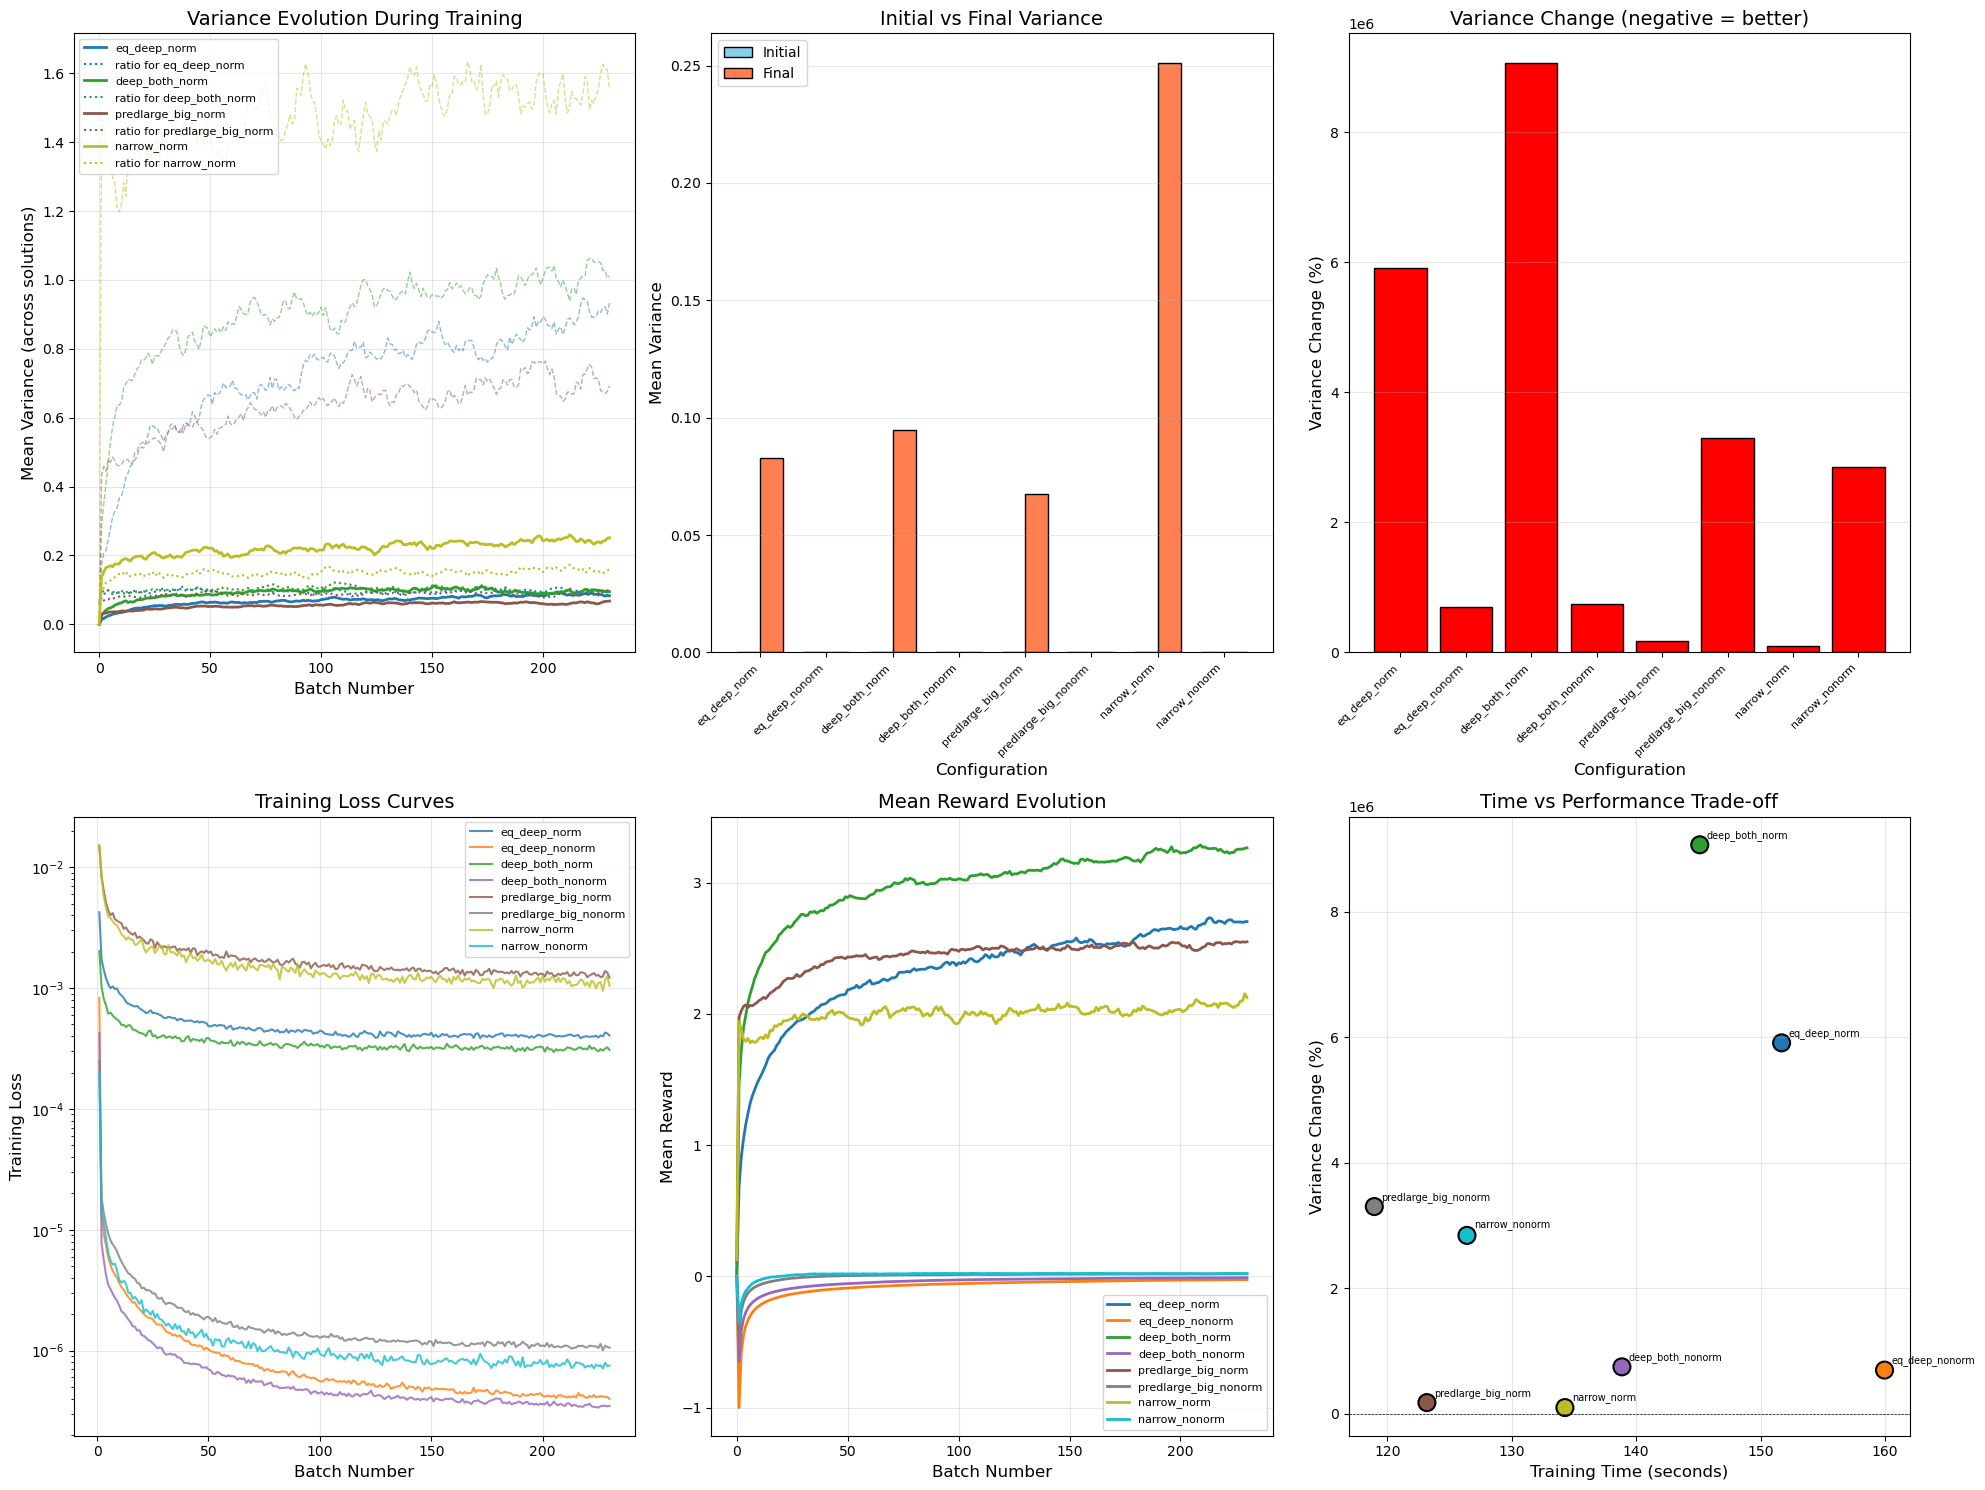


EXPERIMENT RESULTS SUMMARY
Config                   Init Var    Final Var     Change %     Time (s)   Final Reward
------------------------------------------------------------------------------------------
eq_deep_norm               0.0000       0.0827   +5913215.9        151.7         2.7037
eq_deep_nonorm             0.0000       0.0000    +698410.7        160.0        -0.0249
deep_both_norm             0.0000       0.0947   +9069323.4        145.1         3.2655
deep_both_nonorm           0.0000       0.0000    +750392.8        138.9        -0.0101
predlarge_big_norm         0.0000       0.0674    +180516.3        123.2         2.5493
predlarge_big_nonorm       0.0000       0.0000   +3304521.0        119.0         0.0191
narrow_norm                0.0002       0.2512    +101130.7        134.3         2.1240
narrow_nonorm              0.0000       0.0001   +2844956.1        126.4         0.0212


In [92]:
# Plot comparison of all experiments
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
comparison_plot_path = os.path.join(SAVE_DIR, f"buffer_experiment_comparison_{timestamp}.pdf")
plot_experiment_comparison(all_experiment_results, save_path=comparison_plot_path)

C:\Users\spand\AppData\Local\Temp\ipykernel_24540\718932230.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(final_variances_list, labels=config_names, patch_artist=True)


Saved detailed analysis to: results2\buffer_variance_analysis_20251130_001533.png


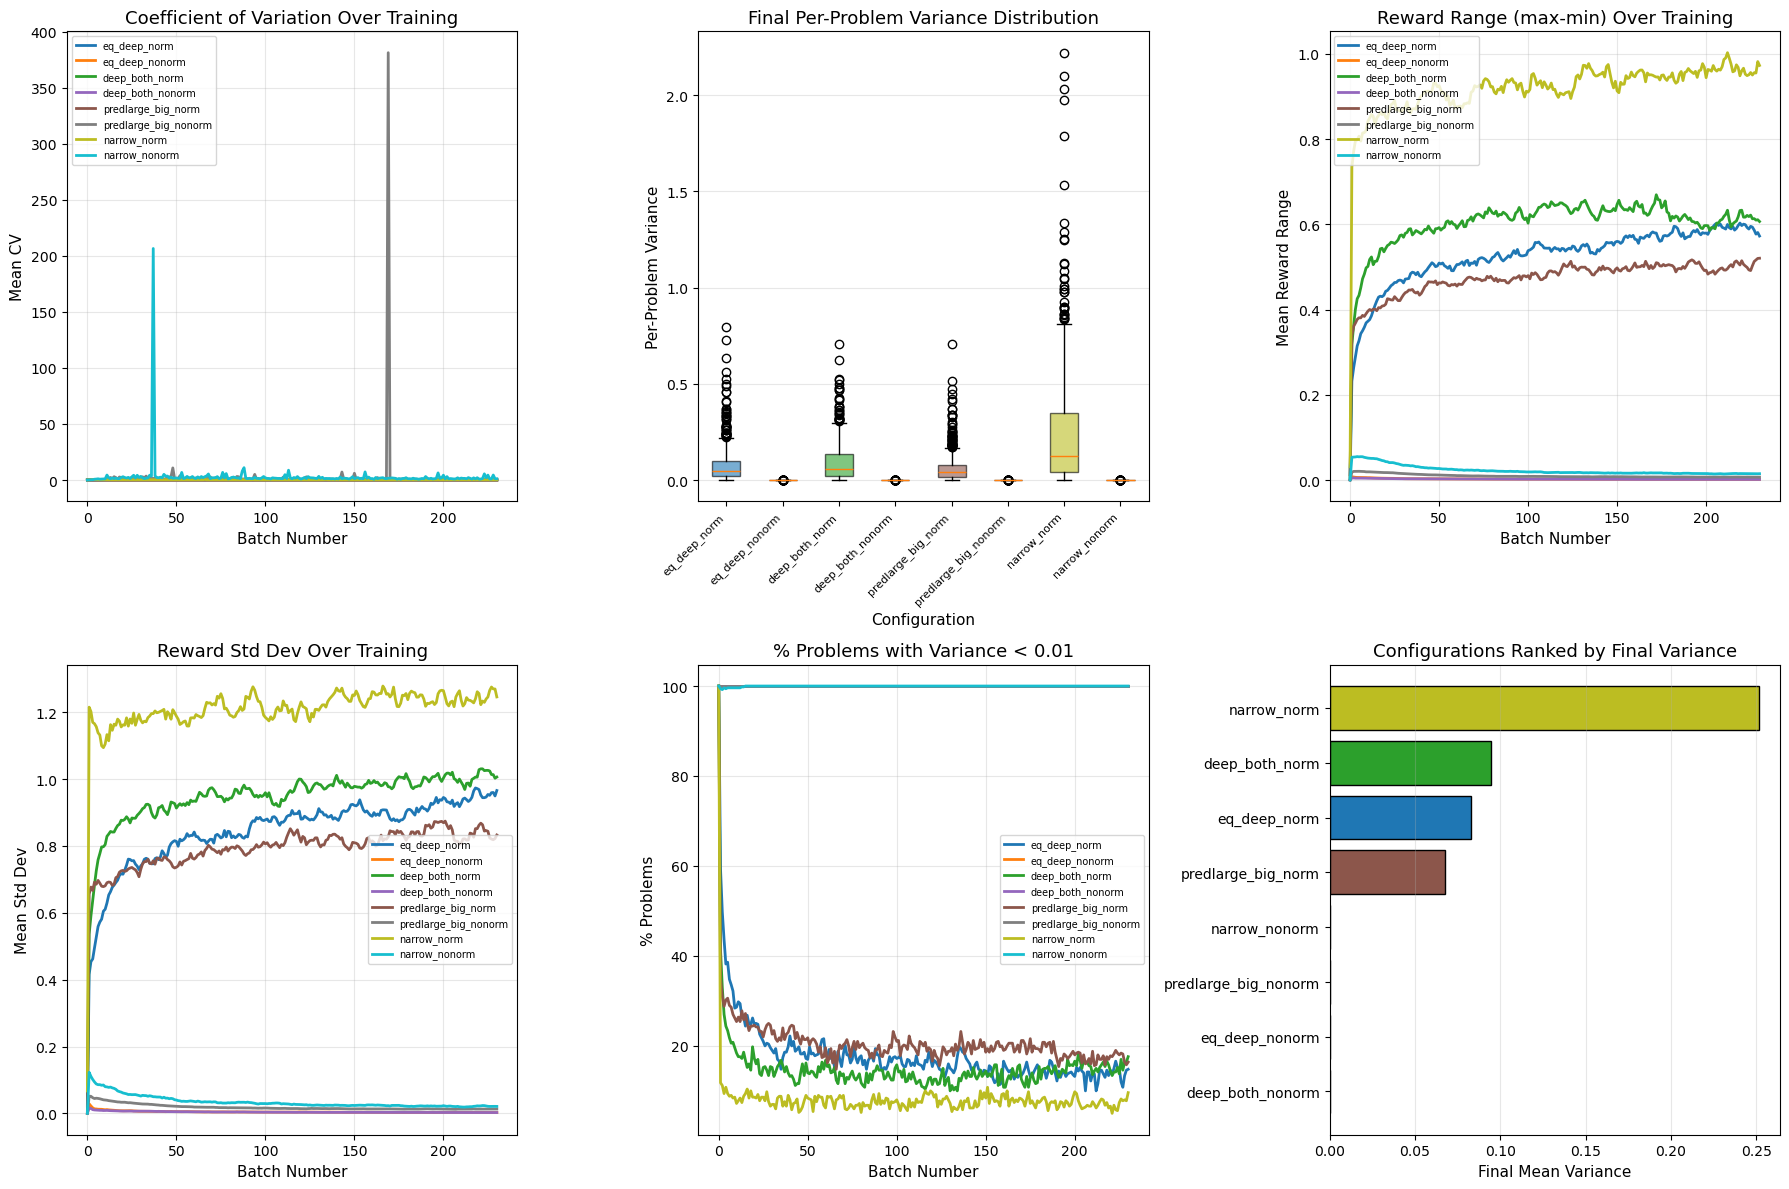

In [93]:
# =============================================================================
# DETAILED VARIANCE ANALYSIS PLOTS
# =============================================================================

def plot_detailed_variance_analysis(all_results: List[Dict], save_path: str = None):
    """
    Create detailed variance analysis plots comparing experiments.
    """
    num_experiments = len(all_results)
    config_names = [r['config']['name'] for r in all_results]
    colors = plt.cm.tab10(np.linspace(0, 1, num_experiments))
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Coefficient of Variation over time
    ax1 = axes[0, 0]
    for i, r in enumerate(all_results):
        timestamps = r['results']['batch_timestamps']
        cv = np.mean(r['metrics']['cv_per_problem'], axis=1)
        ax1.plot(timestamps, cv, label=r['config']['name'], color=colors[i], linewidth=2)
    ax1.set_xlabel('Batch Number', fontsize=11)
    ax1.set_ylabel('Mean CV', fontsize=11)
    ax1.set_title('Coefficient of Variation Over Training', fontsize=13)
    ax1.legend(fontsize=7, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribution of final per-problem variances
    ax2 = axes[0, 1]
    final_variances_list = [r['metrics']['per_problem_variance'][-1] for r in all_results]
    bp = ax2.boxplot(final_variances_list, labels=config_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax2.set_xlabel('Configuration', fontsize=11)
    ax2.set_ylabel('Per-Problem Variance', fontsize=11)
    ax2.set_title('Final Per-Problem Variance Distribution', fontsize=13)
    ax2.set_xticklabels(config_names, rotation=45, ha='right', fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Reward spread (max - min across 3 solutions) over time
    ax3 = axes[0, 2]
    for i, r in enumerate(all_results):
        rewards_hist = r['results']['rewards_history']
        timestamps = r['results']['batch_timestamps']
        reward_range = np.max(rewards_hist, axis=2) - np.min(rewards_hist, axis=2)
        mean_range = np.mean(reward_range, axis=1)
        ax3.plot(timestamps, mean_range, label=r['config']['name'], color=colors[i], linewidth=2)
    ax3.set_xlabel('Batch Number', fontsize=11)
    ax3.set_ylabel('Mean Reward Range', fontsize=11)
    ax3.set_title('Reward Range (max-min) Over Training', fontsize=13)
    ax3.legend(fontsize=7, loc='best')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Standard deviation of rewards per solution over time
    ax4 = axes[1, 0]
    for i, r in enumerate(all_results):
        timestamps = r['results']['batch_timestamps']
        std_per_eval = np.mean(r['metrics']['std_reward_per_solution'], axis=1)
        ax4.plot(timestamps, std_per_eval, label=r['config']['name'], color=colors[i], linewidth=2)
    ax4.set_xlabel('Batch Number', fontsize=11)
    ax4.set_ylabel('Mean Std Dev', fontsize=11)
    ax4.set_title('Reward Std Dev Over Training', fontsize=13)
    ax4.legend(fontsize=7, loc='best')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Percentage of problems with "low" variance over time
    ax5 = axes[1, 1]
    LOW_VAR_THRESHOLD = 0.01  # Define what counts as "low" variance
    for i, r in enumerate(all_results):
        timestamps = r['results']['batch_timestamps']
        per_problem_var = r['metrics']['per_problem_variance']
        pct_low_var = np.mean(per_problem_var < LOW_VAR_THRESHOLD, axis=1) * 100
        ax5.plot(timestamps, pct_low_var, label=r['config']['name'], color=colors[i], linewidth=2)
    ax5.set_xlabel('Batch Number', fontsize=11)
    ax5.set_ylabel('% Problems', fontsize=11)
    ax5.set_title(f'% Problems with Variance < {LOW_VAR_THRESHOLD}', fontsize=13)
    ax5.legend(fontsize=7, loc='best')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Final variance comparison - sorted
    ax6 = axes[1, 2]
    final_mean_vars = [np.mean(r['metrics']['per_problem_variance'][-1]) for r in all_results]
    sorted_indices = np.argsort(final_mean_vars)
    sorted_names = [config_names[i] for i in sorted_indices]
    sorted_vars = [final_mean_vars[i] for i in sorted_indices]
    sorted_colors = [colors[i] for i in sorted_indices]
    bars = ax6.barh(sorted_names, sorted_vars, color=sorted_colors, edgecolor='black')
    ax6.set_xlabel('Final Mean Variance', fontsize=11)
    ax6.set_title('Configurations Ranked by Final Variance', fontsize=13)
    ax6.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved detailed analysis to: {save_path}")
    
    plt.show()

# Generate detailed variance analysis
detailed_plot_path = os.path.join(SAVE_DIR, f"buffer_variance_analysis_{timestamp}.png")
plot_detailed_variance_analysis(all_experiment_results, save_path=detailed_plot_path)

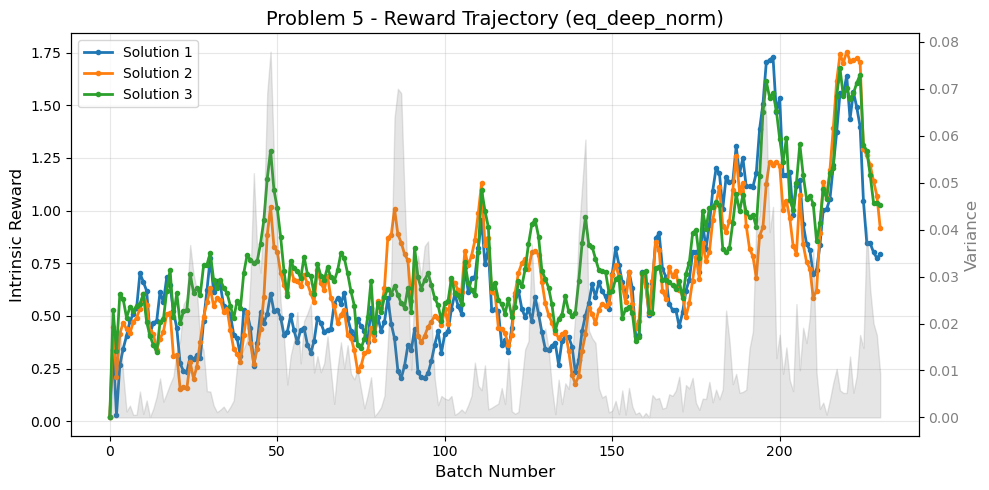

Problem 5 stats:
  Initial variance: 0.0000
  Final variance: 0.0093
  Change: +1763533.9%


In [94]:
# =============================================================================
# INDIVIDUAL PROBLEM TRAJECTORY PLOTS
# =============================================================================

def plot_problem_trajectory(results: Dict, problem_idx: int, config_name: str = ""):
    """Plot reward trajectory for a single problem across all 3 solutions."""
    rewards_history = results['rewards_history']
    batch_timestamps = results['batch_timestamps']
    
    num_evals, num_problems, num_solutions = rewards_history.shape
    
    if problem_idx >= num_problems:
        print(f"Error: problem_idx {problem_idx} >= num_problems {num_problems}")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    for sol_idx in range(num_solutions):
        rewards = rewards_history[:, problem_idx, sol_idx]
        ax.plot(batch_timestamps, rewards, marker='o', markersize=3, 
                label=f'Solution {sol_idx+1}', linewidth=2)
    
    ax.set_xlabel('Batch Number', fontsize=12)
    ax.set_ylabel('Intrinsic Reward', fontsize=12)
    title = f'Problem {problem_idx} - Reward Trajectory'
    if config_name:
        title = f'{title} ({config_name})'
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    variance_over_time = np.var(rewards_history[:, problem_idx, :], axis=1)
    ax2 = ax.twinx()
    ax2.fill_between(batch_timestamps, 0, variance_over_time, alpha=0.2, color='gray', label='Variance')
    ax2.set_ylabel('Variance', color='gray', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='gray')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Problem {problem_idx} stats:")
    print(f"  Initial variance: {variance_over_time[0]:.4f}")
    print(f"  Final variance: {variance_over_time[-1]:.4f}")
    print(f"  Change: {(variance_over_time[-1] - variance_over_time[0]) / variance_over_time[0] * 100:+.1f}%")


def plot_multi_config_problem_comparison(all_results: List[Dict], problem_idx: int = 0):
    """Compare how a single problem behaves across different configurations."""
    num_configs = len(all_results)
    
    fig, axes = plt.subplots(2, (num_configs + 1) // 2, figsize=(5 * ((num_configs + 1) // 2), 10))
    axes = axes.flatten()
    
    for i, exp_result in enumerate(all_results):
        ax = axes[i]
        config_name = exp_result['config']['name']
        results = exp_result['results']
        rewards_history = results['rewards_history']
        batch_timestamps = results['batch_timestamps']
        
        for sol_idx in range(3):
            rewards = rewards_history[:, problem_idx, sol_idx]
            ax.plot(batch_timestamps, rewards, marker='o', markersize=2, 
                    label=f'Sol {sol_idx+1}', linewidth=1.5)
        
        ax.set_xlabel('Batch')
        ax.set_ylabel('Reward')
        ax.set_title(config_name, fontsize=11)
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplot if odd number
    if num_configs < len(axes):
        for i in range(num_configs, len(axes)):
            axes[i].set_visible(False)
    
    plt.suptitle(f'Problem {problem_idx}: Comparison Across Configurations', fontsize=14)
    plt.tight_layout()
    plt.show()


# View individual problem trajectories for the baseline
PROBLEM_TO_VIEW = 5
if len(all_experiment_results) > 0:
    baseline_result = all_experiment_results[0]
    plot_problem_trajectory(
        baseline_result['results'], 
        problem_idx=PROBLEM_TO_VIEW,
        config_name=baseline_result['config']['name']
    )

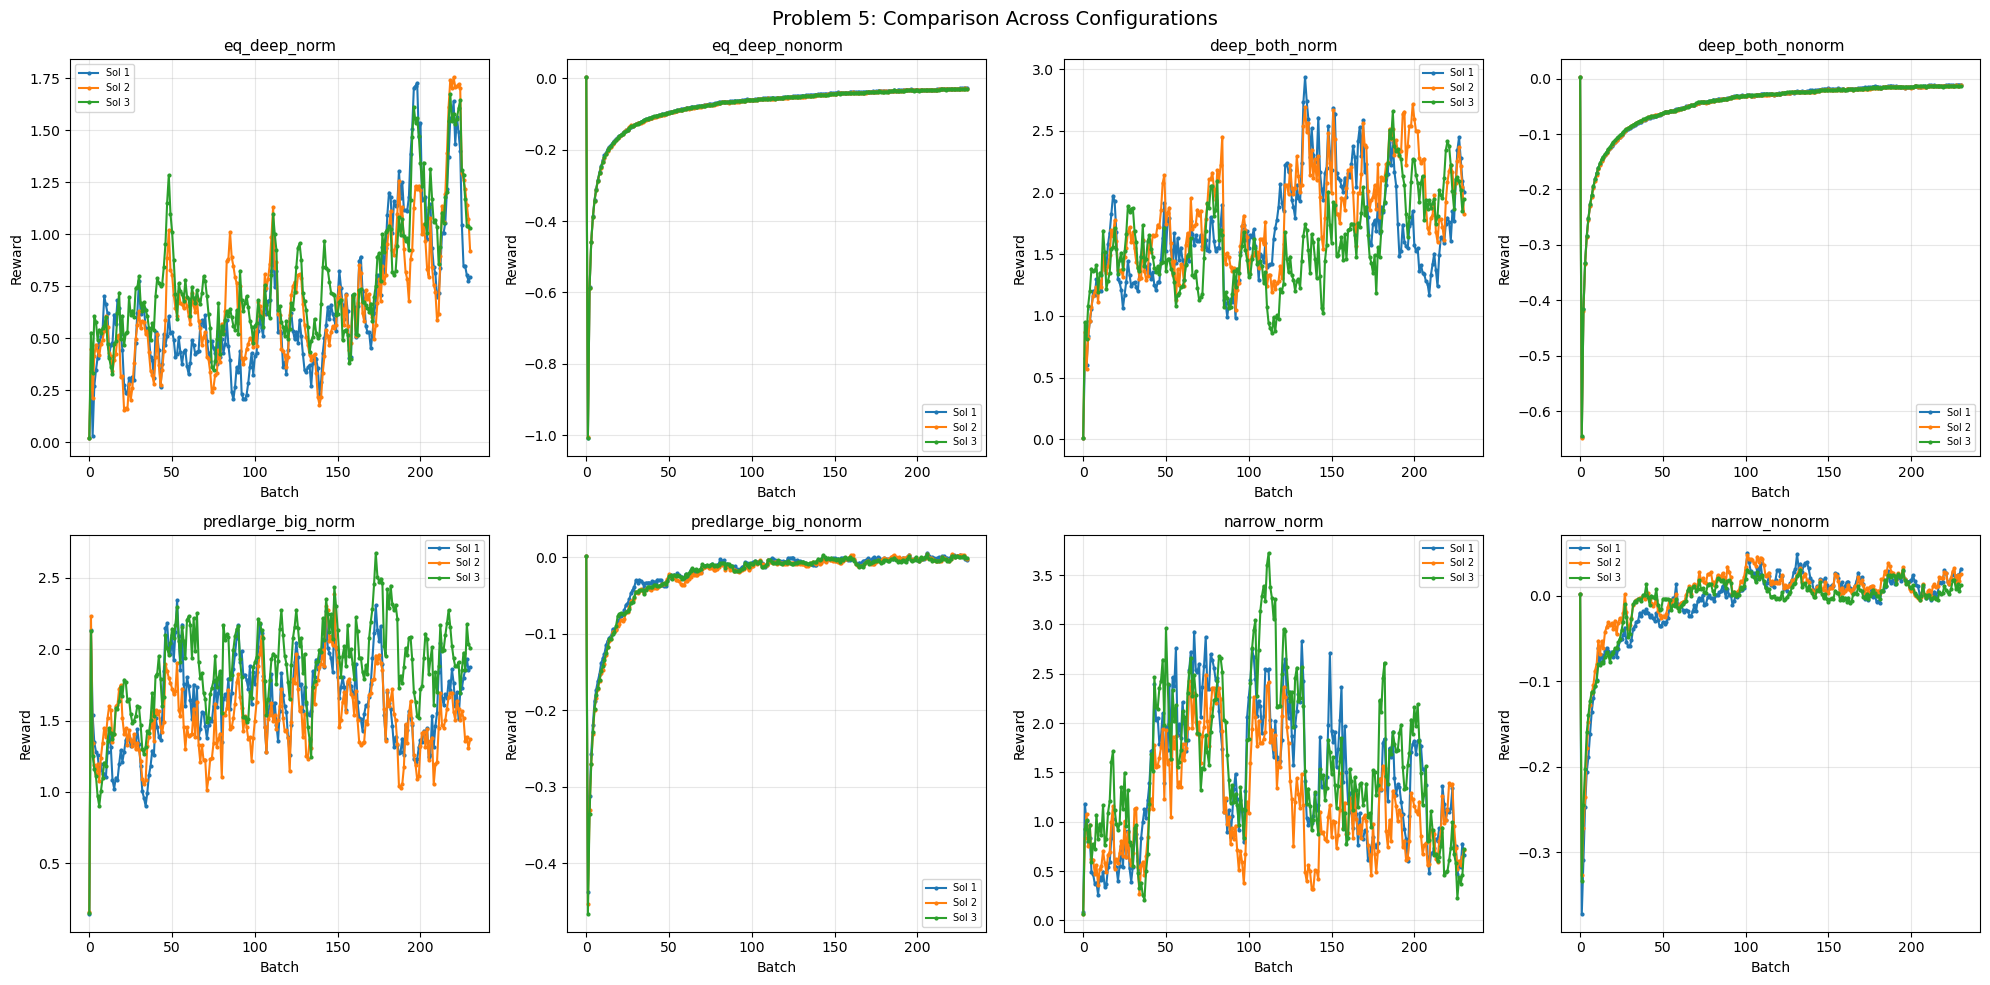

In [95]:
# Compare how Problem 5 behaves across all configurations
plot_multi_config_problem_comparison(all_experiment_results, problem_idx=PROBLEM_TO_VIEW)

In [96]:
# =============================================================================
# SAVE ALL EXPERIMENT RESULTS
# =============================================================================

def save_all_experiment_results(all_results: List[Dict], save_dir: str, prefix: str = ""):
    """Save all experiment results to a JSON file."""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{prefix}all_experiments_{timestamp}.json"
    filepath = os.path.join(save_dir, filename)
    
    # Prepare data for JSON serialization
    serializable_results = []
    for exp in all_results:
        serializable_results.append({
            'config': exp['config'],
            'metrics_summary': {
                'initial_variance': float(exp['metrics']['mean_variance_per_eval'][0]),
                'final_variance': float(exp['metrics']['mean_variance_per_eval'][-1]),
                'variance_change_pct': float((exp['metrics']['mean_variance_per_eval'][-1] - 
                                              exp['metrics']['mean_variance_per_eval'][0]) / 
                                             exp['metrics']['mean_variance_per_eval'][0] * 100),
                'training_time_seconds': float(exp['results']['total_time']),
                'mean_final_reward': float(np.mean(exp['results']['rewards_history'][-1])),
                'num_batches': int(exp['results']['config']['num_batches']),
            },
            'variance_over_time': exp['metrics']['mean_variance_per_eval'].tolist(),
            'training_losses': exp['results']['training_losses'].tolist(),
            'batch_timestamps': exp['results']['batch_timestamps'].tolist(),
        })
    
    with open(filepath, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    
    print(f"Saved all experiment results to: {filepath}")
    return filepath

# Save all results
save_all_experiment_results(all_experiment_results, SAVE_DIR, prefix="buffer_")

Saved all experiment results to: results2\buffer_all_experiments_20251130_001546.json


'results2\\buffer_all_experiments_20251130_001546.json'